# Datos y metadatos de los ligandos

## Obtención de los datos de los ligandos  cocristalizados con CDK2

> Puntos clave de esta libreta:
- Se extrae de la tabla de datos principal de la proteína las conformaciones que poseen a algún ligando en el sitio activo.
- Se crea un set de moléculas usando identificador PDB de cada molécula (cada molécula es designada con un id de 3 letras).
- Se usa el id de cada molécula (LIG) para obtener los datos de la página `http://www.rcsb.org/ligand/LIG`, correspondiente a cada ligando. Con ello obtenemos:
    - El smile isomérico de la molécula.
    - El InChI
    - El InChI Key
- Usamos el **InChI** para obtener los datos de cada molécula desde _**PUBCHEM**_ y _**CHEMBL**_.
- Guardamos los datos en un diccionario y a su vez lo exportamos a un archivo pinckle.

## Cargamos los datos de la tabla principal

In [328]:
import pandas as pd
import numpy as np
import glob

Nombre de la proteína:

In [2]:
prot_name = 'cdk2'

Cargamos el dataframe principal de la proteína:

In [355]:
# Este es el DF que no tiene aun afgregados los valores AUC de las conformaciones
df_prot_labels = pd.read_json('./B_DATOS/TABLA_MTDATA_CDK2_402_crys_LIGS_INFO_LABELS.json')
df_prot_labels.shape

(402, 15)

## Identificación de los inhibidores
### Seleccionamos las conformaciones que posean algun inhibidor

In [390]:
filtro_inh = df_prot_labels.Inhib != ''
df_ligs_crys = df_prot_labels[filtro_inh]

In [391]:
# Número total de conformaciones con algún ligando en el sitio activo
df_ligs_crys.shape

(367, 15)

### Identificamos el número de ligandos únicos

In [397]:
ligs_crys_prot = set(df_ligs_crys.Inhib)
len(ligs_crys_prot)

317

## Comenzamos la obtención de los datos
### Web scrapping de los ligandos

In [393]:
# Librerías útiles para el web scrapping de los ligandos
import urllib.request
from bs4 import BeautifulSoup
from chembl_webresource_client.new_client import new_client
import pubchempy

In [394]:
# Url para accesar a la información de los ligandos en el PDB
URL_PDB = 'http://www.rcsb.org/ligand'

### Obtenemos los datos de cada ligando y los guardamos en un diccionario

In [ ]:
# Generamos un diccionario con los datos de la molécula
dic_ligs_crys_prot = {}

for ligando in ligs_crys_prot[:
    url_lig = F'{URL_PDB}/{ligando}'
    print(F'Procesando al ligando: {ligando}\n')
    
    # Extraemos los datos del html del ligando:
    lig_data = urllib.request.urlopen( url_lig ).read().decode()
    
    # Extraemos del bsoup los siguientes datos:
    # InChIKey
    soup = BeautifulSoup(lig_data)
    inchi_key = soup.find("tr", {"id": "chemicalInChIKey"})
    inchi_key_str = inchi_key.find('td').text
    
    # InChI
    inchi = soup.find("tr", {"id": "chemicalInChI"})
    inchi_str = inchi.find('td').text
    
    # isomeric SMILE (por si no se encuentra en la API de PbCh)
    smiles = soup.find("tr", {"id": "chemicalIsomeric"})
    smiles_str = smiles.find('td').text
    
    # Peso molecular
    mw = soup.find("tr", {"id": "chemicalMolecularWeight"})
    mw_str = mw.find('td').text
    
    # Con los datos anteriores usamos la librería para accesar al Chembl
    # **** CHEMBL ****
    # Procedemos a extraer los datos del Chembl
    molecule = new_client.molecule
    try:
        chblMol_info = molecule.get(inchi_key_str)
        chembl_id = chblMol_info['molecule_chembl_id']
    except:
        print(F'No se pudo obtener infor de CEHMBL: {ligando}')
        print(inchi_str + '\n')
        chblMol_info = None
        chembl_id = None
        
    # Ahora obtenemos datos correspondientes a pubchem
    # *** PUBCHEM ***
    try:
        pbch_mol = pubchempy.get_compounds(inchi_str, 'inchi')[0]
        pbch_cid = pbch_mol.cid
        pbch_data = pbch_mol.to_dict()
        canonical_smiles = pbch_mol.canonical_smiles
    except:
        print(F'Fallo con datos PUBCHEM: {ligando}')
        pbch_mol = None
        pbch_cid = None
        pbch_data = None
        canonical_smiles = None
    # Creamos la entrada para el diccionario
    # Primero el diccionario del ligando
    dic_lig = {'inchi_key': inchi_key_str,
               'inchi': inchi_str,
               'molecular_weight': float(mw_str),
               'canonical_smiles': canonical_smiles,
               'isomeric_similes': smiles_str,
               'chembl_id': chembl_id,
               'chembl_data': chblMol_info,
               'pubchem_id': pbch_cid,
               'pubchem_data': pbch_data,}
    
    # Anidamos el dict  del ligando al dic principal
    dic_ligs_crys_prot[ligando] = dic_lig

## Guardamos el set de datos en formato json

In [12]:
import pickle
import os

nombre_archivo = './B_DATOS/LIGS_CDK2_crys_pubchem_chembl_data.pkl'
if not os.path.exists(nombre_archivo):
    with open(nombre_archivo, 'wb') as dic_file:
        pickle.dump(dic_ligs_crys_prot, dic_file, protocol=pickle.HIGHEST_PROTOCOL)
else:
    print("El archivo ya ha sido creado.")

El archivo ya ha sido creado.


### Lectura del del archivo guardado

In [16]:
# Lectura del diccionario con pickle
nombre_archivo = './B_DATOS/LIGS_CDK2_crys_pubchem_chembl_data.pkl'
with open(nombre_archivo, 'rb') as dic_file:
    dic_ligs_crys_prot = pickle.load(open(nombre_archivo, 'rb'))

# Finalmente:
## Uso del diccionario final
A modo de ejemplo visualizamos algunos de los datos disponibles en el diccionario:

In [ ]:
import rdkit as rd

ID Chembl: CHEMBL14249
cid Pubchem: 5957
Nombre: ADENOSINE TRIPHOSPHATE


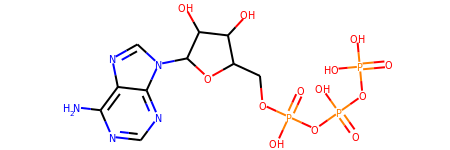

In [334]:
# Obtención del un ligando a través de una conformación
lig_1aq1 = df_ligs_crys.loc['1fin', 'Inhib']
# Imprimimos su nombre y otros datos interesantes
lig_1aq1_data = dic_ligs_crys_prot[lig_1aq1]
print(F'ID Chembl: {lig_1aq1_data["chembl_id"]}')
print(F'cid Pubchem: {lig_1aq1_data["pubchem_id"]}')
print(F'Nombre: {lig_1aq1_data["chembl_data"]["pref_name"]}')
# Obtenemos el smiles canonico
lig_1aq1_smiles = dic_ligs_crys_prot[lig_1aq1]['canonical_smiles']
# Lo visualizamos con rdkit
rd.Chem.MolFromSmiles(lig_1aq1_smiles)

ID Chembl: CHEMBL388978
Cid Pubchem: 44259
Nombre: STAUROSPORINE


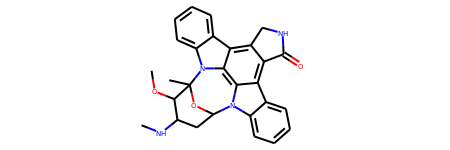

In [335]:
# Obtención del un ligando a través de una conformación
lig_1aq1 = df_ligs_crys.loc['1aq1', 'Inhib']
# Imprimimos su nombre y otros datos interesantes
lig_1aq1_data = dic_ligs_crys_prot[lig_1aq1]
print(F'ID Chembl: {lig_1aq1_data["chembl_id"]}')
print(F'Cid Pubchem: {lig_1aq1_data["pubchem_id"]}')
print(F'Nombre: {lig_1aq1_data["chembl_data"]["pref_name"]}')
# Obtenemos el smiles canonico
lig_1aq1_smiles = dic_ligs_crys_prot[lig_1aq1]['canonical_smiles']
# Lo visualizamos con rdkit
rd.Chem.MolFromSmiles(lig_1aq1_smiles)

# DUD PRUEBAS

In [ ]:
import rdkit as rd

In [23]:
#Convertir el archivo mol2 a sdf para poserlo parsear con rdkit
dud_actives = '../ARCHIVOS/CRISTALES/LIGS_CDK2/DUDE_DECOYS/DUD_2006/dud_ligands2006/cdk2_ligands'

In [184]:
%%bash -s "$dud_actives"
obabel -imol2 ${1}.mol2 -osmi -O ${1}.smi

72 molecules converted


In [148]:
a = rd.Chem.SDMolSupplier(dud_actives + '.sdf', False)

In [159]:
contador_lineas = 0
s = set()
with open(F'{dud_actives}.smi', "r") as file:
    for i, line in enumerate(file):
        contador_lineas += 1
        s.add(line)
contador_lineas
len(s)

58

In [296]:
# Extremos del set los smiles
dic_dud_mols = {}
# ordenamos el set
set_ordenado = sorted(s, key = lambda x: int(x.replace('\n', '').split('ZINC')[1]))
for i, string in enumerate(set_ordenado):
    split_string = string.replace('\n', '').split('\t')
    mol_name = F'{i}_{split_string[1]}'
    mol_smile = split_string[0]
    mol_rdkit = rd.Chem.MolFromSmiles(mol_smile, False)
    dic_dud_mols[mol_name] = mol_rdkit

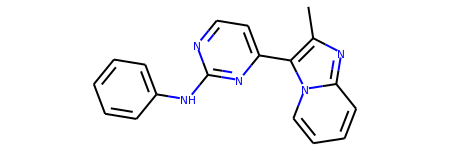

In [299]:
dic_dud_mols['25_ZINC03814452']

RDKit ERROR: [10:52:11] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6 7 8
RDKit ERROR: 


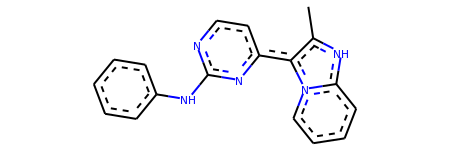

In [303]:
dic_dud_mols['26_ZINC03814452']

In [304]:
# Un set para ver si hay repetidos en los smiles
set_smiles = set()
for i in dic_dud_mols:
    set_smiles.add(i)
    
len(set_smiles) == len(dic_dud_mols)

True

In [305]:
# Extraemos los smiles de los activos de DUD
dud_smiles_iso = []
for key,smi in dic_dud_mols.items():
    smi = rd.Chem.MolToSmiles(smi, isomericSmiles=True)
    dud_smiles_iso.append( smi )

#dud_smiles_iso

In [306]:
# Generamos el diccionario de moléculas cocristalizadas 
dic_crys_mols = {}
for key in dic_ligs_crys_prot:
    # Usamos el smile isomérico, pues no de todos los ligandos fue posible obtener el canónico
    # Debido a que el API de Chembl no está actualizada (moleculas depositadas en 2019 suelen dar error)
    # Aunque rdkit, puede proveerlo una vez cargada la molécula
    smile = dic_ligs_crys_prot[key]['isomeric_similes']
    mol = rd.Chem.MolFromSmiles(smile, False)
    dic_crys_mols[key] = mol

len(dic_crys_mols )

317

In [307]:
# Extraemos los smiles canónicos de las moléculas cocristalizadas
crys_smiles_iso = []
for key,smi in dic_crys_mols.items():
    smi = rd.Chem.MolToSmiles(smi, isomericSmiles=True )
    crys_smiles_iso.append( smi)

#crys_smiles_iso

In [272]:
# preguntamos qué moléculas
for dud in dud_smiles_iso:
    if dud in crys_smiles_iso:
        #print('1')

SyntaxError: unexpected EOF while parsing (<ipython-input-272-6885ce898f12>, line 4)

In [308]:
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols

In [309]:
dic_fps_dud = {i: rd.Chem.RDKFingerprint(j) for i, j in dic_dud_mols.items()}
dic_fps_crys = {i: rd.Chem.RDKFingerprint(j) for i, j in dic_crys_mols.items()}

In [310]:
DataStructs.FingerprintSimilarity(dic_fps_dud['0_ZINC00003491'], dic_fps_crys['ATP'])

0.2589105581708137

In [323]:
contador_sim = 0
cutoff = 1
# Comparamos similitud entre los ligandos
for name_dud, fps_dud in dic_fps_dud.items():
    for name_crys, fps_crys in dic_fps_crys.items():
        # Comparamos ambas estructuras usando los fingerprints
        similarity = DataStructs.FingerprintSimilarity(fps_dud, fps_crys)
        if similarity >= cutoff:
            contador_sim += 1
            print(contador_sim, name_dud, name_crys)

1 1_ZINC00023543 CMG
2 7_ZINC00603011 4SP
3 9_ZINC01641925 OLO
4 10_ZINC01649340 RRC
5 11_ZINC03591113 I17
6 13_ZINC03814434 STU
7 14_ZINC03814435 UCN
8 15_ZINC03814437 PVB
9 17_ZINC03814440 INR
10 19_ZINC03814443 LS1
11 20_ZINC03814444 LS2
12 21_ZINC03814447 LS4
13 22_ZINC03814449 1PU
14 24_ZINC03814451 ST8
15 31_ZINC03814457 MBP
16 34_ZINC03814460 UN4
17 35_ZINC03814461 6CP
18 36_ZINC03814462 2A6
19 41_ZINC03814467 SU9
20 42_ZINC03814467 SU9
21 51_ZINC03814479 NW1
22 52_ZINC03814479 NW1
23 56_ZINC04617747 LS5


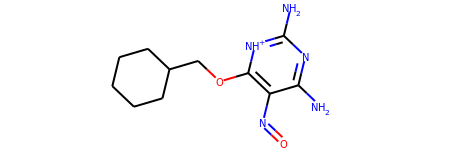

In [324]:
dic_dud_mols['51_ZINC03814479']

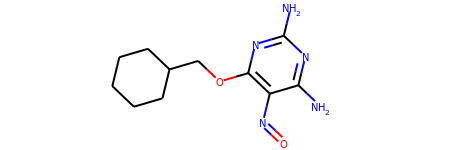

In [326]:
dic_dud_mols['52_ZINC03814479']

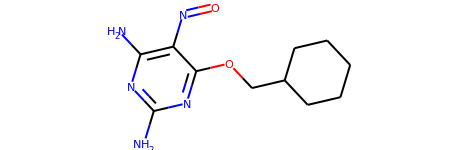

In [327]:
dic_crys_mols['NW1']

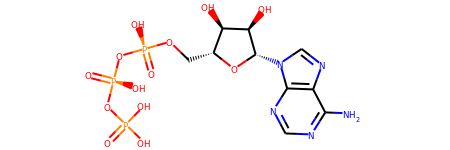

In [66]:
dic_crys_mols['ATP']

In [67]:
# Cálculo de los fingerprints